# IMPORTING ALL LIBRARIES AND READING THE APPLE STOCK DATASET

In [71]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

stock_data = yf.download('AAPL', start='2016-01-01', end='2022-12-31')
stock_data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.111502,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.507278,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.047245,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.074553,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.191275,283192000


In [72]:
stock_data.shape


(1762, 6)

# VISUALIZIING THE STOCK DATA

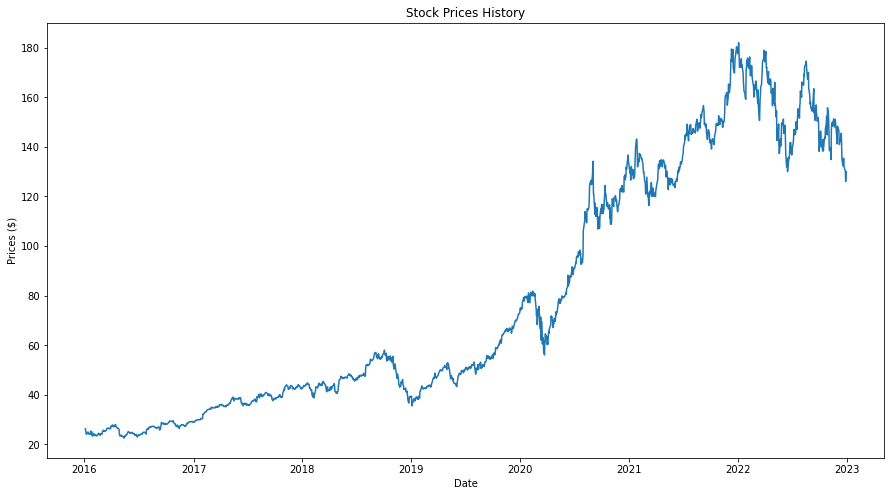

In [73]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.show()


# PREPARATION OF TRAINING SET

In [99]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))



# PREPARATION OF TEST SET

In [98]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


# BUILDING THE MODEL ARCHITECTURE

In [86]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dense_10 (Dense)            (None, 25)                2525      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


# TRAINING LSTM MODEL

In [87]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1350/1350 [==============================] - 28s 16ms/step - loss: 0.0012
Epoch 2/3
1350/1350 [==============================] - 22s 16ms/step - loss: 5.5983e-04
Epoch 3/3
1350/1350 [==============================] - 21s 16ms/step - loss: 4.9267e-04


# MODEL EVALUATION

In [88]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

11/11 [==============================] - 2s 29ms/step


3.3020810213955967

# VISUALISING THE PREDICTED PRICES

C:\Users\Sid\AppData\Local\Temp\ipykernel_56720\154904543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


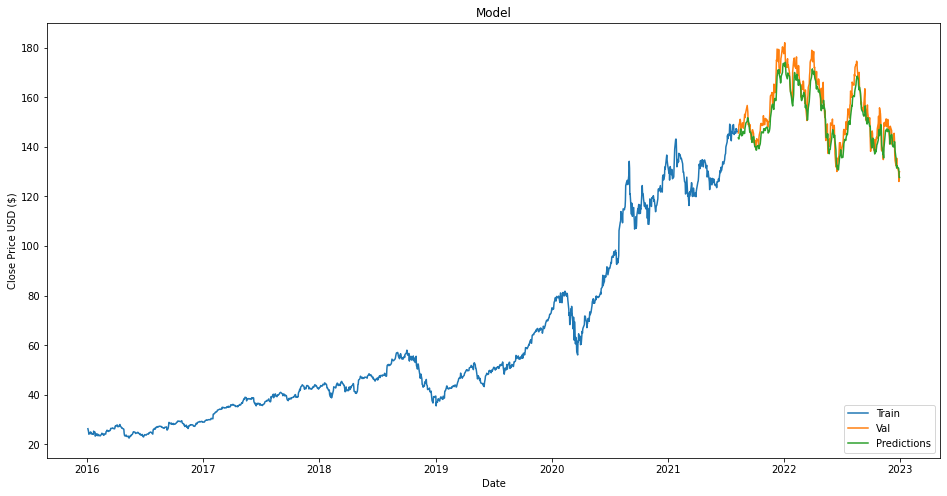

In [89]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [96]:
validation

,Close,Predictions
Date,,
2021-08-10,145.600006,143.637100
2021-08-11,145.860001,143.262085
2021-08-12,148.889999,143.171356
2021-08-13,149.100006,144.490311
2021-08-16,151.119995,145.498917
...,...,...
2022-12-23,131.860001,131.965683
2022-12-27,130.029999,131.363724
2022-12-28,126.040001,130.180206
